#Deep Learning Architectures Assignment 1
## Assignment 1 - Feed Forward neural network
The goal is define neural network, write code for forward and backward pass, training loop and perform training.

## TODO:
1. Define feed forward neural network:
    *   Define at at least 2 hidden layers.
    *   At least 10 neurons.
    *   At least one layer with ReLU activation function: **`relu(x) = max(0,x)`**.
    *   Output layer with Sigmoid activation function.
    *   Loss function should use (binary) cross entropy function.
    *   Optimization should use batch gradient descent (gradient computed for entire training set).
    *   All should be written using Numpy only.
2. Draw computation graph of the network.

##Notes:
Please note that example code included with Logistic Regression using convension where batch dimension is the last one: X vector is defineds as [features, batch] where code here uses convention used by most of the frameworks whebe batch dimension comes first [batch, features].

In [49]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import random
from urllib.request import urlopen

def download_dataset(file_id):
  filename = f"dataset{file_id}.h5"
  base_url = f"https://github.com/pa-k/AGU/blob/main/assignment1/{filename}?raw=true"
  url = urlopen(base_url)
  binary_data = url.read()
  with open(filename,"wb") as f:
    f.write(binary_data)

def import_dataset(file_id):
  filename = f"dataset{file_id}.h5"
  if not os.path.exists(filename):
    download_dataset(file_id)
  fp = h5py.File(filename, "r")
  x_train = np.array(fp["x_train"][:])
  y_train = np.array(fp["y_train"][:])
  x_test = np.array(fp["x_test"][:])
  y_test = np.array(fp["y_test"][:])
  fp.close()
  return x_train, y_train, x_test, y_test


student_id = 184657     #Your id
file_id = student_id%17

x_train, y_train, x_test, y_test = import_dataset(file_id)

assert x_train.shape == (600, 32, 32, 3)
assert x_test.shape == (200, 32, 32, 3)
assert y_train.shape == (600, 1)
assert y_test.shape == (200, 1)

#Sample image

Label: [0.]


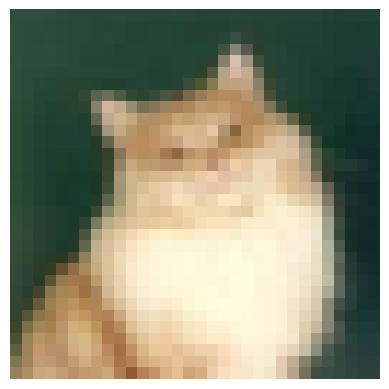

In [50]:
index = random.randint(0,x_train.shape[0]-1)
plt.axis('off')
plt.imshow(x_train[index])
print("Label: " + str(y_train[index]))

#Flatten and normalize data

In [51]:
x_train = x_train.reshape(x_train.shape[0], -1)/255
x_test = x_test.reshape(x_test.shape[0], -1)/255

#Dataset Dimensions

In [52]:
print ("Dataset dimensions:")
print ("Number of training examples: m_train = " + str(x_train.shape[1]))
print ("Number of testing examples: m_test = " + str(x_test.shape[1]))
print ("train_x shape: " + str(x_train.shape))
print ("train_y shape: " + str(y_train.shape))
print ("test_x shape: " + str(x_test.shape))
print ("test_y shape: " + str(y_test.shape))

Dataset dimensions:
Number of training examples: m_train = 3072
Number of testing examples: m_test = 3072
train_x shape: (600, 3072)
train_y shape: (600, 1)
test_x shape: (200, 3072)
test_y shape: (200, 1)


#Paste here diagram of the computation graph and indicate variables used in the propagate function

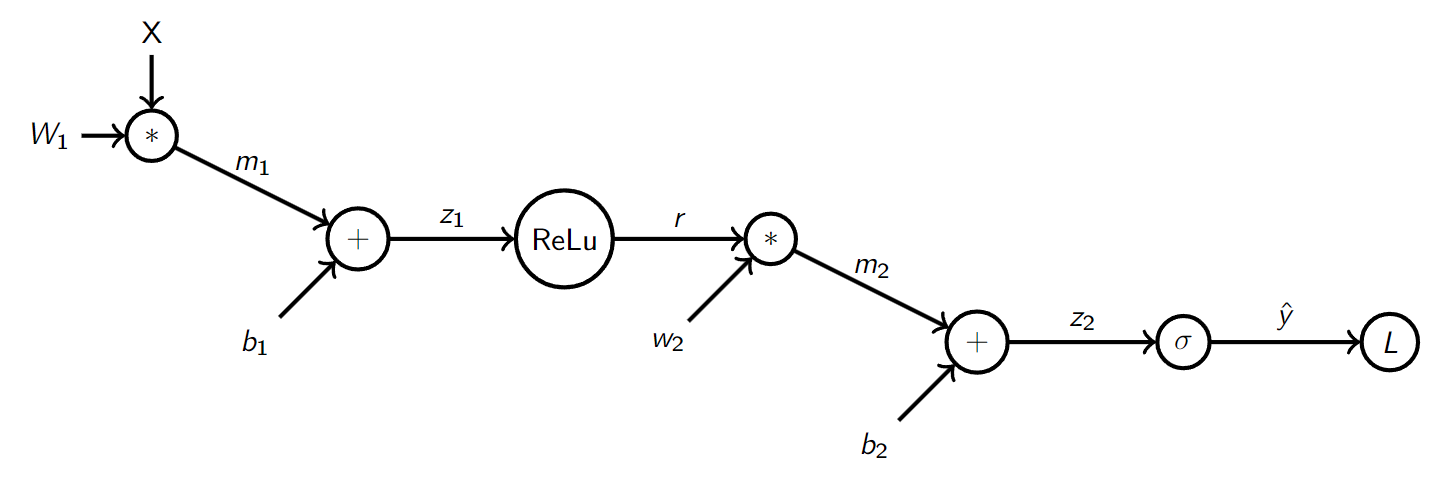

$m_1 = X \cdot W_1$

$z_1 = m_1 + b_1$

$r = max(z_1, 0)$

$m_2 = r \cdot W_2$

$z_2 = m_2 + b_2$

$\hat{y} = \sigma(z_2)$

$L = -(y\log\hat{y} + (1 - y)\log(1 - \hat{y}))$


---

$\frac{\delta L}{\delta L} = 1$

$\frac{\delta L}{\delta \hat{y}} = -\frac{y}{\log\hat{y}} + \frac{1-y}{\log(1-\hat{y})}$

$\frac{\delta  \hat{y}}{\delta z_2} = \sigma(z_2)(1 - \sigma(z_2))$

$\frac{\delta z_2}{\delta b_2} = \frac{\delta z_2}{\delta m_2} = \frac{\delta z_1}{\delta b_1} = \frac{\delta z_1}{\delta m_1} = 1$

$\frac{\delta r}{\delta z_1} = \begin{cases}
0, & \text{dla} & x \lt 0\\
1, & \text{dla} & x \ge 0
\end{cases}$

#Define forward and back propagation

In [53]:
class NeuralNet(object):

    def __init__(self, input_size):
        """
        input size - number of features of the input
        """
        #Fix definition of weight matrices and biases, use np.random.uniform function
        # At least 10 neurons
        self.neurons_cnt = 10
        W1 = np.random.uniform(-0.1, 0.1, (input_size, self.neurons_cnt))
        b1 = np.random.uniform(-0.1, 0.1, (1, self.neurons_cnt))
        W2 = np.random.uniform(-0.1, 0.1, (self.neurons_cnt, 1))
        b2 = np.random.uniform(-0.1, 0.1, (1, 1))

        self.params = {'W1': W1,
                       'b1': b1,
                       'W2': W2,
                       'b2': b2}
        self.grads = {}


    def cross_entropy(self, y, y_hat):
        return -np.mean(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))


    def relu(self, z):
        return np.maximum(z, 0)


    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))


    def predict(self, X):
    #write code to do prediction: for input set of images (dimension [batch,features]) it should set predictions vector [batch] indicatating image class

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        z1 = np.dot(X, W1) + b1
        z2 = np.dot(self.relu(z1), W2) + b2
        predictions = self.sigmoid(z2)

        return predictions


    def propagate(self, X, y):
        y = y.reshape(-1, 1)   #fix y vector to have shape [batch,1]
        nbatch = y.shape[0]

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        #forward pass - you should at least calculate cost function (average loss for all examples in a batch)
        m1 = np.dot(X, W1)
        z1 = m1+b1
        r = self.relu(z1)
        m2 = np.dot(r, W2)
        z2 = m2+b2
        y_hat = self.sigmoid(z2)
        cost = self.cross_entropy(y=y, y_hat=y_hat)

        #backward pass - get values of dW1, dW2,db1,db2
        dy_hat = -y / y_hat + (1-y) / (1-y_hat)
        dz2 = y_hat * (1-y_hat) * dy_hat
        db2 = (1/nbatch) * np.sum(dz2, axis=0, keepdims=True)
        dW2 = (1/nbatch) * np.dot(r.T, dz2)
        dr = np.dot(dz2, W2.T)
        dz1 = dr * (z1 > 0)
        db1 = (1 / nbatch) * np.sum(dz1, axis=0, keepdims=True)
        dW1 = (1 / nbatch) * np.dot(X.T, dz1)

        self.grads = {'dW1': dW1,
                      'db1': db1,
                      'dW2': dW2,
                      'db2': db2}

        return cost


    def update(self, alpha):
        #calculate new values of network parames (self.params) based on learning rate alpha and gradients (self.grads)
        W1 = self.params["W1"] - alpha * self.grads["dW1"]
        b1 = self.params["b1"] - alpha * self.grads["db1"]
        W2 = self.params["W2"] - alpha * self.grads["dW2"]
        b2 = self.params["b2"] - alpha * self.grads["db2"]

        self.params = {'W1': W1,
                       'b1': b1,
                       'W2': W2,
                       'b2': b2}

        pass

#Train model

In [54]:
alpha = 0.01
net = NeuralNet(x_train.shape[1])
for i in range(10000):
    loss = net.propagate(x_train, y_train)
    net.update(alpha)
    if i % 100 == 0:
        y_pred_train = net.predict(x_train)
        y_pred_test = net.predict(x_test)
        print(loss)
        print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

0.6913278103807532
train accuracy: 50.14368472105596 %
test accuracy: 49.925430664347324 %
0.6844575693616971
train accuracy: 50.52608757686484 %
test accuracy: 50.24365698714644 %
0.6757530038005173
train accuracy: 51.034874780219205 %
test accuracy: 50.573703136723466 %
0.6619941445783106
train accuracy: 51.874018578690766 %
test accuracy: 51.09065343269758 %
0.6415971588926908
train accuracy: 53.17638909049979 %
test accuracy: 51.94473389547411 %
0.6142679081830461
train accuracy: 55.019888427490685 %
test accuracy: 53.19475940404826 %
0.5834234656547546
train accuracy: 57.247097660196886 %
test accuracy: 54.68250422850869 %
0.5543346529748799
train accuracy: 59.5203711743851 %
test accuracy: 56.16834630540172 %
0.5291911200291676
train accuracy: 61.58854545782058 %
test accuracy: 57.46600272346906 %
0.5078054839682657
train accuracy: 63.38301380322292 %
test accuracy: 58.545136740205194 %
0.48917294394281685
train accuracy: 64.93435912547953 %
test accuracy: 59.435145840981804 %
0.